# Open Access Evidence in Unpaywall using Python

*Analyzing the open access status of scholarly articles is a challenging task that many libraries, universities and researchers are facing. In this blog post, we discuss a Python based approach for analyzing journal articles using the Unpaywall database. In particular, we build upon the results of an existing blog article which used R and provide a new python implementation.* 

The [Unpaywall](https://unpaywall.org/) database is a collection of millions of scholarly fulltext articles that were harvested from a variety of different repositories and services like [PubMed Central](https://www.ncbi.nlm.nih.gov/pmc/) and [DOAJ](https://doaj.org/). Although Unpaywall offers a REST API to query the Unpaywall database, it is more convenient and efficient to use the provided [database snapshots](https://unpaywall.org/products/snapshot), which are usually released twice a year.

In this blog post, we discuss the results from the blog article "[Open Access Evidence in Unpaywall](https://subugoe.github.io/scholcomm_analytics/posts/unpaywall_evidence/)" by Najko Jahn and Anne Hobert by comparing different database snapshots obtained from Unpaywall. Since the article was published on May 7th, 2019, Unpaywall has recently released a new data dump with up-to-date information about scholarly journal articles. Therefore it might be interesting to see how the change in data impacts the results of our analysis compared to the previous blog article. For this post we are using the Unpaywall data dump from November 2019.

In order to query the Unpaywall dataset, which is stored in Google BigQuery, we use the [google-cloud-bigquery](https://googleapis.dev/python/bigquery/latest/index.html) package. By default, this package is not shipped with [pandas](https://pandas.pydata.org/). However, we recommend to use this package along with pandas to have a better experience. The major reason for this being, that the queried data can easily be exported into a pandas DataFrame. 

In [1]:
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot

The setup for the Google BigQuery Python client is very simple. Firstly, we import bigquery from the google.cloud package and create a client object by passing the project name as a parameter. If we didn´t set our credentials for the Google Cloud service yet, Google asks us to verify our client. This can be done by simply exporting an API-Key provided by Google into the working environment or by installing the official [Google Cloud SDK](https://cloud.google.com/sdk). A detailed description on how to authenticate the client can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html). Notice that our project-database has restricted access.

In [2]:
%%capture
client = bigquery.Client(project='api-project-764811344545')

According to the aforementioned blog article, the dataset being used has two tables, containing records between 2008 and 2018. For reusability, we define two variables, which are holding the table´s names to call them in SQL queries. We are also using the improved string formatting syntax which is a new feature since Python 3.6.

In [3]:
# database snapshots
upw_08_12 = '`oadoi_full.mongo_export_upwNov19_08_12`'
upw_13_18 = '`oadoi_full.mongo_export_upwNov19_13_19`'

We can query the project-database by using the `query` method on our created client object. In this example we were requesting ten journal articles that were published in 2018. We can pass the SQL query simply as a string into our `query` method. Next we can chain the `to_dataframe` method on our query to get a pandas DataFrame.

In [4]:
client.query(f"""
            SELECT * 
            FROM {upw_13_18} 
            WHERE year=2018
            AND genre="journal-article" 
            LIMIT 10
            """).to_dataframe()

oa_status  year            genre                          updated  \
0      gold  2018  journal-article 2019-11-01 22:51:32.142428+00:00   
1    bronze  2018  journal-article 2019-10-31 06:40:37.599979+00:00   
2      gold  2018  journal-article 2019-10-31 16:20:21.743703+00:00   
3      gold  2018  journal-article 2019-11-07 06:20:25.027034+00:00   
4      gold  2018  journal-article 2019-11-01 04:59:15.673051+00:00   
5     green  2018  journal-article 2019-11-14 20:18:43.150844+00:00   
6     green  2018  journal-article 2019-11-16 23:50:30.876520+00:00   
7      gold  2018  journal-article 2019-11-16 20:20:50.499946+00:00   
8     green  2018  journal-article 2019-10-31 01:01:45.923146+00:00   
9      gold  2018  journal-article 2019-10-31 10:50:00.933552+00:00   

  published_date  journal_is_in_doaj  journal_is_oa        journal_issns  \
0     2018-03-29                True           True            1560-7917   
1     2018-01-01               False          False  0035-2764,1950-6694   
2     2018-03-12                True           True            1664-3224   
3     2018-08-07                True           True            2045-2322   
4     2018-01-26                True           True            1664-302X   
5     2018-12-07               False          False  0305-8719,2041-4927   
6     2018-11-29               False          False  2470-0010,2470-0029   
7     2018-01-23               False           True            2291-0026   
8     2018-10-06               False          False  1387-2877,1875-8908   
9     2018-04-10                True           True            1664-462X   

                                        oa_locations  \
0  [{'url': 'https://doi.org/10.2807/1560-7917.es...   
1  [{'url': 'https://www.cairn.info/load_pdf.php?...   
2  [{'url': 'https://www.frontiersin.org/articles...   
3  [{'url': 'https://www.nature.com/articles/s415...   
4  [{'url': 'https://www.frontiersin.org/articles...   
5  [{'url': 'https://hal.archives-ouvertes.fr/hal...   
6  [{'url': 'https://helda.helsinki.fi/bitstream/...   
7  [{'url': 'http://www.cmajopen.ca/content/6/1/E...   
8  [{'url': 'http://spiral.imperial.ac.uk/bitstre...   
9  [{'url': 'https://www.frontiersin.org/articles...   

                                        doi  is_oa  \
0  10.2807/1560-7917.es.2018.23.13.180329-3   True   
1                     10.3917/reco.695.0683   True   
2                  10.3389/fimmu.2018.00438   True   
3                10.1038/s41598-018-29997-0   True   
4                  10.3389/fmicb.2018.00019   True   
5                          10.1144/sp467.15   True   
6                10.1103/physrevd.98.103533   True   
7                    10.9778/cmajo.20170159   True   
8                        10.3233/jad-180101   True   
9                   10.3389/fpls.2018.00470   True   

                                           publisher  \
0  European Centre for Disease Control and Preven...   
1                                              CAIRN   
2                                 Frontiers Media SA   
3                       Springer Nature America, Inc   
4                                 Frontiers Media SA   
5                       Geological Society of London   
6                    American Physical Society (APS)   
7                                         Joule Inc.   
8                                          IOS Press   
9                                 Frontiers Media SA   

                                       journal_name  data_standard  
0                                  Eurosurveillance              2  
1                                  Revue économique              2  
2                           Frontiers in Immunology              2  
3                                Scientific Reports              2  
4                         Frontiers in Microbiology              2  
5  Geological Society, London, Special Publications              2  
6                                 Physical Review D              2  
7 

## Open Access availability (is_oa)

To contrast the previous results from the blog article with the recent results, we begin with a comparison of the total number of articles between the two datasets from February 2019 and November 2019. More importantly, we will investigate the open access share between these two.

Before we can compute the open access proportion in our dataset, we must query our database and count the number of distinct DOI´s by year and open access status. Since we have two tables, we need to concatenate our dataframes in the next step. We also have to convert the column which contains the year from string to datetime. This allows us to handle date informations much better when visualizing data. After we have calculated the proportion of open access by year, we will now sort the values by time.

In [5]:
oa_08_12 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_08_12} 
                        WHERE genre="journal-article" 
                        GROUP BY year, is_oa
                        """).to_dataframe()

oa_13_18 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_13_18} 
                        WHERE year<2019 AND genre="journal-article" 
                        GROUP BY year, is_oa
                        """).to_dataframe()

In [6]:
df = pd.concat([oa_08_12, oa_13_18])
df.year = pd.to_datetime(df.year.apply(lambda x: str(x) + "-01-01"))
df['prop'] = df.groupby(['year'])['n'].transform(lambda x: x / x.sum())
df = df.sort_values(by=['year']).reset_index(drop=True)
df.head()

year  is_oa        n      prop
0 2008-01-01   True   646079  0.312379
1 2008-01-01  False  1422175  0.687621
2 2009-01-01   True   730604  0.323450
3 2009-01-01  False  1528180  0.676550
4 2010-01-01   True   823574  0.328862

For visualization, we are using [matplotlib](https://matplotlib.org/). Matplotlib is a commonly used plotting library for Python that is influenced by [Matlab](https://www.mathworks.com/products/matlab.html) and enables a wide range of different plot figures. Even though pandas allows us to directly call a plot method on a DataFrame, we feel more comfortable with using essential matplotlib methods. Especially, when customizing the figure. 

In our first plot we visualize the open access share to journal articles over time. Whereas our plot is not interactive like in the stated blog article, we could make use of the same plotting library named Plotly which can be found [here](https://plot.ly/). Plotly is available for R, Javascript and Python.

In [7]:
# increase plot resolution
plt.rcParams['figure.dpi'] = 600

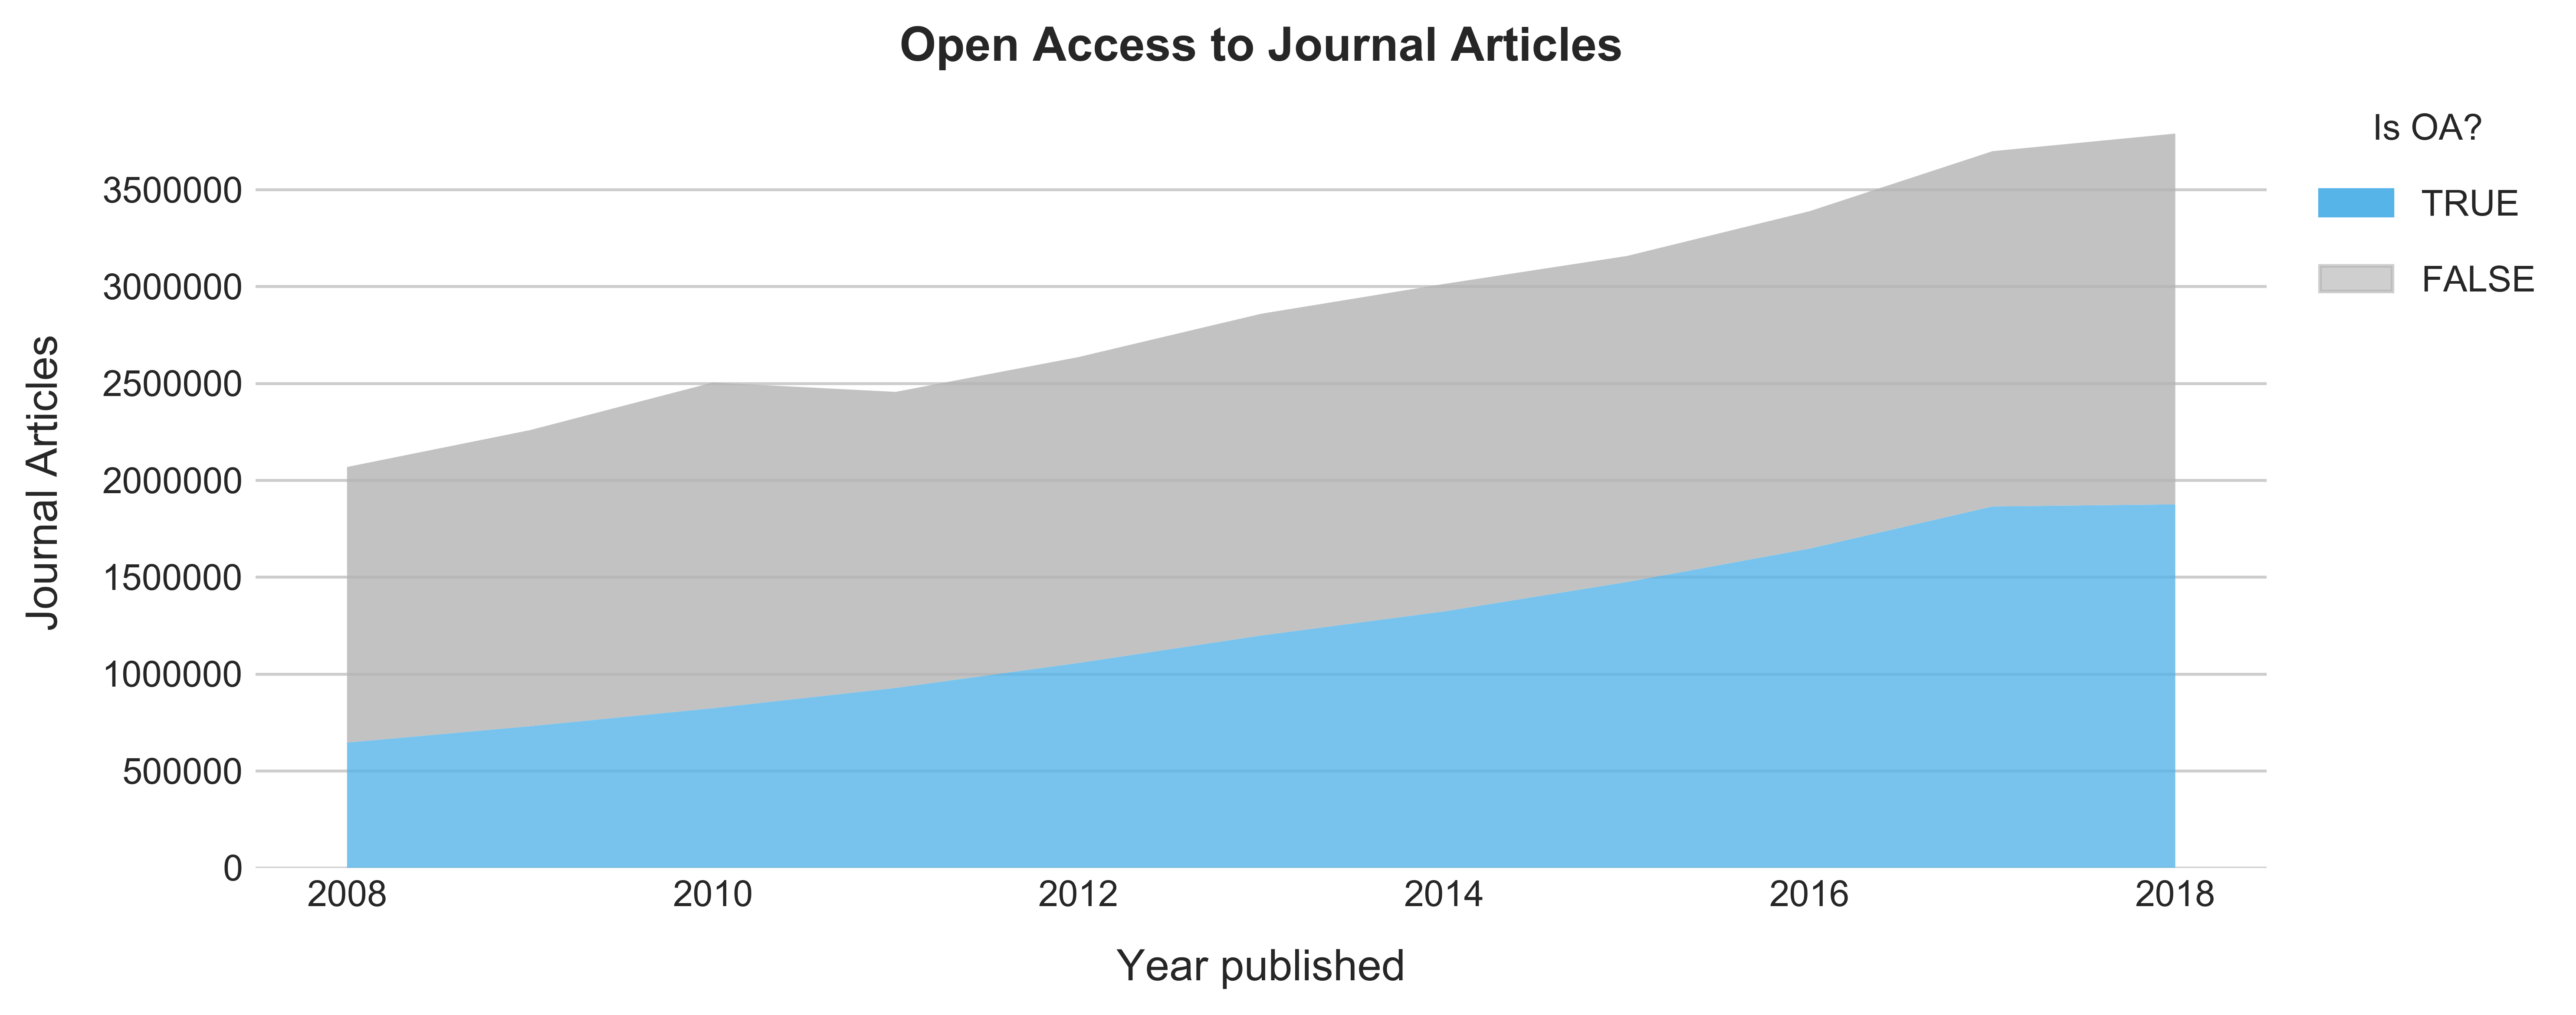

In [8]:
x = df.year.unique()
y1 = df[df.is_oa == True].n
y2 = df[df.is_oa == False].n

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [10, 4]
plt.grid(False, which='both', axis='x')
plt.box(False)
plt.stackplot(x, y1, y2, colors=['#56B4E9', '#b3b3b3a0'], alpha=0.8)
plt.title('Open Access to Journal Articles', 
          fontdict={'fontsize': 13, 'fontweight': 600},
          pad=10)
plt.xlabel('Year published', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})
plt.ylabel('Journal Articles', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})
is_oa_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_oa_patch, is_not_oa_patch], title='Is OA?',
           fontsize='medium', bbox_to_anchor=(1.15, 1.02), labelspacing=1.2)

plt.tight_layout()

plt.show()

As expected, the total number of journal articles has increased, compared to the previous results from the blog article. In fact, the number of articles with a distinct DOI included in the Unpaywall data dump from November 2019 has increased by 2% in comparison to the February 2019 data dump used in the original blog post. In addition, the share of open access articles has increased by 6%. Overall, 13,569,137 freely available articles were published between 2008 and 2018. 

## Unpaywall Open Access Hosting Types (host_type)

Next, we investigate the differences between the distribution of the host types specified in the data dumps. The host type describes the type of location that serves open access full-texts and accepts two values: `publisher` and `repository`. As mentioned in the blog article, the host type variable is determined by Unpaywall’s algorithm. 

In [9]:
HOST_TYPE_08_12_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND is_best=true 
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

HOST_TYPE_13_18_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year<2019 AND is_best=true 
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

Like in the aforementioned blog article, we create a `host` column with the pandas provided `loc` method to highlight freely available full-texts provided by DOAJ in addition to the regular host types. Because DOAJ ensures high quality standards and peer reviews for their indexed journals, it might be interesting to see whether an increase of publishing in potentially less strict open access journals can be observed or not. 

In [10]:
host_type_08_12_query_df = client.query(HOST_TYPE_08_12_QUERY).to_dataframe()
host_type_13_18_query_df = client.query(HOST_TYPE_13_18_QUERY).to_dataframe()

host_type_df = pd.concat([host_type_08_12_query_df, host_type_13_18_query_df])
host_type_df.year = pd.to_datetime(host_type_df.year.apply(lambda x: str(x) + "-01-01"))
host_type_df = host_type_df.sort_values(by=['year']).reset_index(drop=True)

host_type_df.loc[host_type_df['host_type'] == 'publisher', 'host'] = 'Other Journals'
host_type_df.loc[host_type_df['host_type'] == 'repository', 'host'] = 'Repositories only'
host_type_df.loc[host_type_df['journal_is_in_doaj'] == True, 'host'] = 'DOAJ-listed Journal'

host_type_df.head()

year   host_type  journal_is_in_doaj  number_of_articles  \
0 2008-01-01   publisher               False              295155   
1 2008-01-01   publisher                True               92337   
2 2008-01-01  repository               False              258587   
3 2009-01-01   publisher                True              114857   
4 2009-01-01  repository               False              283108   

                  host  
0       Other Journals  
1  DOAJ-listed Journal  
2    Repositories only  
3  DOAJ-listed Journal  
4    Repositories only

Again, we visualize our data with matplotlib. Unlike ggplots for R, we have a more inconvenient way to prepare and plot our data in Python. This starts by iterating over the host types to generate a subplot for each. Although, we can make use of pandas plotting methods to display complicated graphics from DataFrames, it requires much effort to get publication quality figures. 

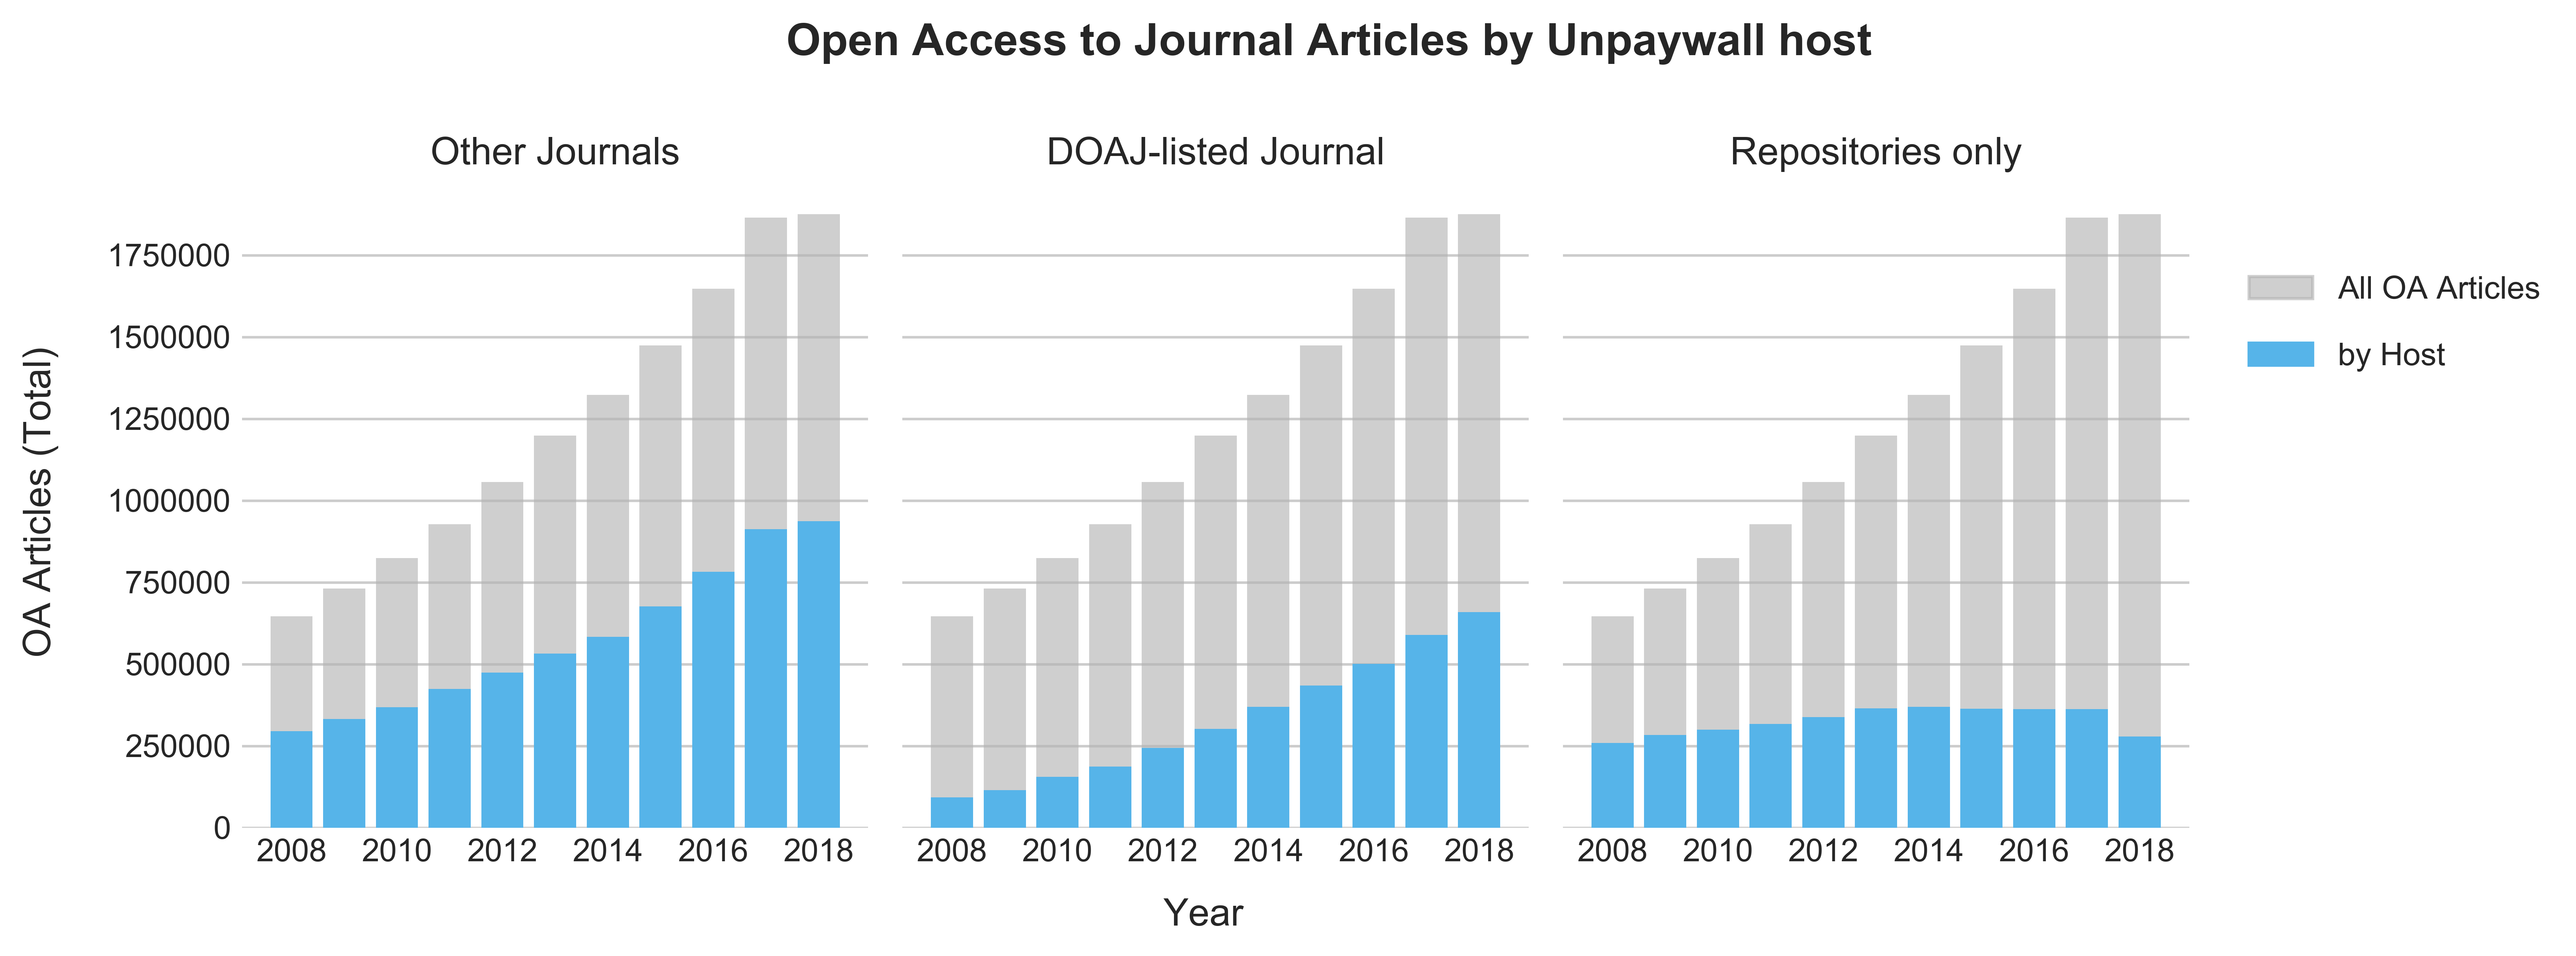

In [11]:
all_articles = host_type_df.groupby(['year'])['number_of_articles'].sum() \
                            .reset_index(name='number_of_articles')

x = all_articles['year'].dt.year
y_total = all_articles.number_of_articles

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5]

fig,(axes) = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Open Access to Journal Articles by Unpaywall host', 
             fontsize=14, 
             fontweight=600, 
             y=1.10)

for i, host in enumerate(host_type_df.host.unique(), 1):
    
    ax = plt.subplot(1,3,i)
    y_stacked = host_type_df[host_type_df.host==host] \
                    .groupby(['year'])['number_of_articles'].sum() \
                    .reset_index(name='number_of_articles').number_of_articles
    ax.bar(x, y_total, color='#b3b3b3a0')
    ax.bar(x, y_stacked, color='#56B4E9')
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})

    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')

    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Articles (Total)', va='center', rotation='vertical', 
         fontdict={'fontsize': 12, 'fontweight': 500})

by_host_patch = mpatches.Patch(color='#56B4E9', label='by Host')
all_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='All OA Articles')
plt.legend(handles=[all_oa_patch, by_host_patch], fontsize='medium',
           bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

fig.tight_layout()

plt.show()

As can be seen from the figure, the proportion of open access articles that are accessible through journals which are not listed in DOAJ has rapidly increased in the year 2018 in comparison to the previous results. Nonetheless, the overall share of articles obtained from Journals that are not listed in DOAJ has decreased from 56% to 47%. Consequently, the share of open access articles provided by DOAJ-listed journals has increased. 

## Unpaywall Open Access Evidence Types (evidence)

In the following, we explore varieties between the evidence types of the two data dumps. The evidence type is a variable determined by Unpaywall, which expresses the location at which an article was found and how Unpaywall was able to identify the open access status of an article.

In [12]:
EVIDENCE_08_12_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(distinct(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" 
                        GROUP BY evidence, year, is_best
                        """

EVIDENCE_13_18_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(distinct(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year < 2019 
                        GROUP BY evidence, year, is_best
                        """

In [13]:
evidence_08_12 = client.query(EVIDENCE_08_12_QUERY).to_dataframe()
evidence_13_18 = client.query(EVIDENCE_13_18_QUERY).to_dataframe()

In [14]:
evidence_df = pd.concat([evidence_08_12, evidence_13_18])
evidence_df.year = pd.to_datetime(evidence_df.year.apply(lambda x: str(x) + "-01-01"))

evidence_df.head()

evidence       year  is_best  \
0  oa repository (semantic scholar lookup) 2011-01-01    False   
1             open (via page says license) 2011-01-01     True   
2                    oa journal (via doaj) 2011-01-01    False   
3         oa repository (via pmcid lookup) 2011-01-01    False   
4        oa journal (via observed oa rate) 2011-01-01    False   

   number_of_articles  
0              285658  
1              177227  
2              138492  
3              219378  
4                9818

For each evidence type we calculate the total number of articles and the related proportion, as well as the cumulative proportion regarding to the number of all articles. Then we display the results in form of a table. To specify the precision of the resulting floating point numbers we again make use of the Python built-in string formatting function. Here we specify by 2 digits of accuracy. 

In [15]:
articles_per_type_df = evidence_df.groupby(['evidence']).number_of_articles \
                        .sum() \
                        .to_frame() \
                        .reset_index() \
                        .sort_values(by=['number_of_articles'], ascending=False) \
                        .reset_index(drop=True)
    
articles_per_type_df['prop'] = articles_per_type_df['number_of_articles'] \
                                .transform(lambda x: 
                                           x / articles_per_type_df['number_of_articles'] \
                                           .sum() * 100)

articles_per_type_df['cumul'] = articles_per_type_df.prop.cumsum()

In [16]:
articles_per_type_table = articles_per_type_df.copy()
articles_per_type_table.prop = articles_per_type_table.prop \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.cumul = articles_per_type_table.cumul \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.columns = ['Evidence Types', 
                                   'Number of Articles', 
                                   'Proportion of all Articles in %', 
                                   'Cumulative Proportion in %']

articles_per_type_table

Evidence Types  Number of Articles  \
0             oa repository (semantic scholar lookup)             5759641   
1               oa repository (via OAI-PMH doi match)             4467382   
2                                 open (via free pdf)             4427452   
3                        open (via page says license)             3653314   
4                               oa journal (via doaj)             3577409   
5                    oa repository (via pmcid lookup)             3237547   
6   oa repository (via OAI-PMH title and first aut...             1699654   
7                   oa journal (via observed oa rate)              781574   
8                         open (via crossref license)              594003   
9                    open (via page says Open Access)              101344   
10                            open (via free article)              100145   
11                    oa journal (via publisher name)               74618   
12     open (via crossref license, author manuscript)               64929   
13            oa repository (via OAI-PMH title match)               51979   
14  oa repository (via OAI-PMH title and last auth...               37218   
15                      oa journal (via issn in doaj)                 392   
16                                             manual                  27   
17                     hybrid (via page says license)                   1   

   Proportion of all Articles in % Cumulative Proportion in %  
0                            20.12                      20.12  
1                            15.60                      35.72  
2                            15.47                      51.19  
3                            12.76                      63.95  
4                            12.50                      76.45  
5                            11.31                      87.75  
6                             5.94                      93.69  
7                             2.73                      96.42  
8                             2.07                      98.50  
9                             0.35                      98.85  
10                            0.35                      99.20  
11                            0.26                      99.46  
12                            0.23                      99.69  
13                            0.18                      99.87  
14                            0.13                     100.00  
15                            0.00                     100.00  
16                            0.00                     100.00  
17                            0.00                     100.00

Interestingly, the evidence type with the highest number of related articles was not included in the previous database snapshot. 

In [17]:
sum_other = articles_per_type_df \
                .loc[articles_per_type_df['prop'] < 1] \
                .number_of_articles \
                .sum()

articles_per_type_other_df = pd.DataFrame([['other', sum_other]], 
                                          columns=['evidence', 'number_of_articles'])

articles_per_type_keep_df = articles_per_type_df.loc[articles_per_type_df['prop'] > 1]

articles_per_type_grouped_df = pd.concat([articles_per_type_other_df, 
                                          articles_per_type_keep_df])

articles_per_type_grouped_df = articles_per_type_grouped_df \
                                .groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

articles_per_type_grouped_df['prop'] = articles_per_type_grouped_df['number_of_articles'] \
                        .transform(lambda x: 
                        x / articles_per_type_grouped_df['number_of_articles'].sum() * 100)

articles_per_type_grouped_df['cumul'] = articles_per_type_grouped_df.prop.cumsum()

In [18]:
evidence_grouped_df = evidence_df.copy()

list_of_small_evidence_types = articles_per_type_df \
                                .loc[articles_per_type_df['prop'] < 1] \
                                .evidence.tolist()

evidence_grouped_df.evidence = evidence_grouped_df \
                                .evidence.replace(list_of_small_evidence_types, 'other')

evidence_grouped_df = evidence_grouped_df.groupby(['evidence', 'is_best', 'year']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

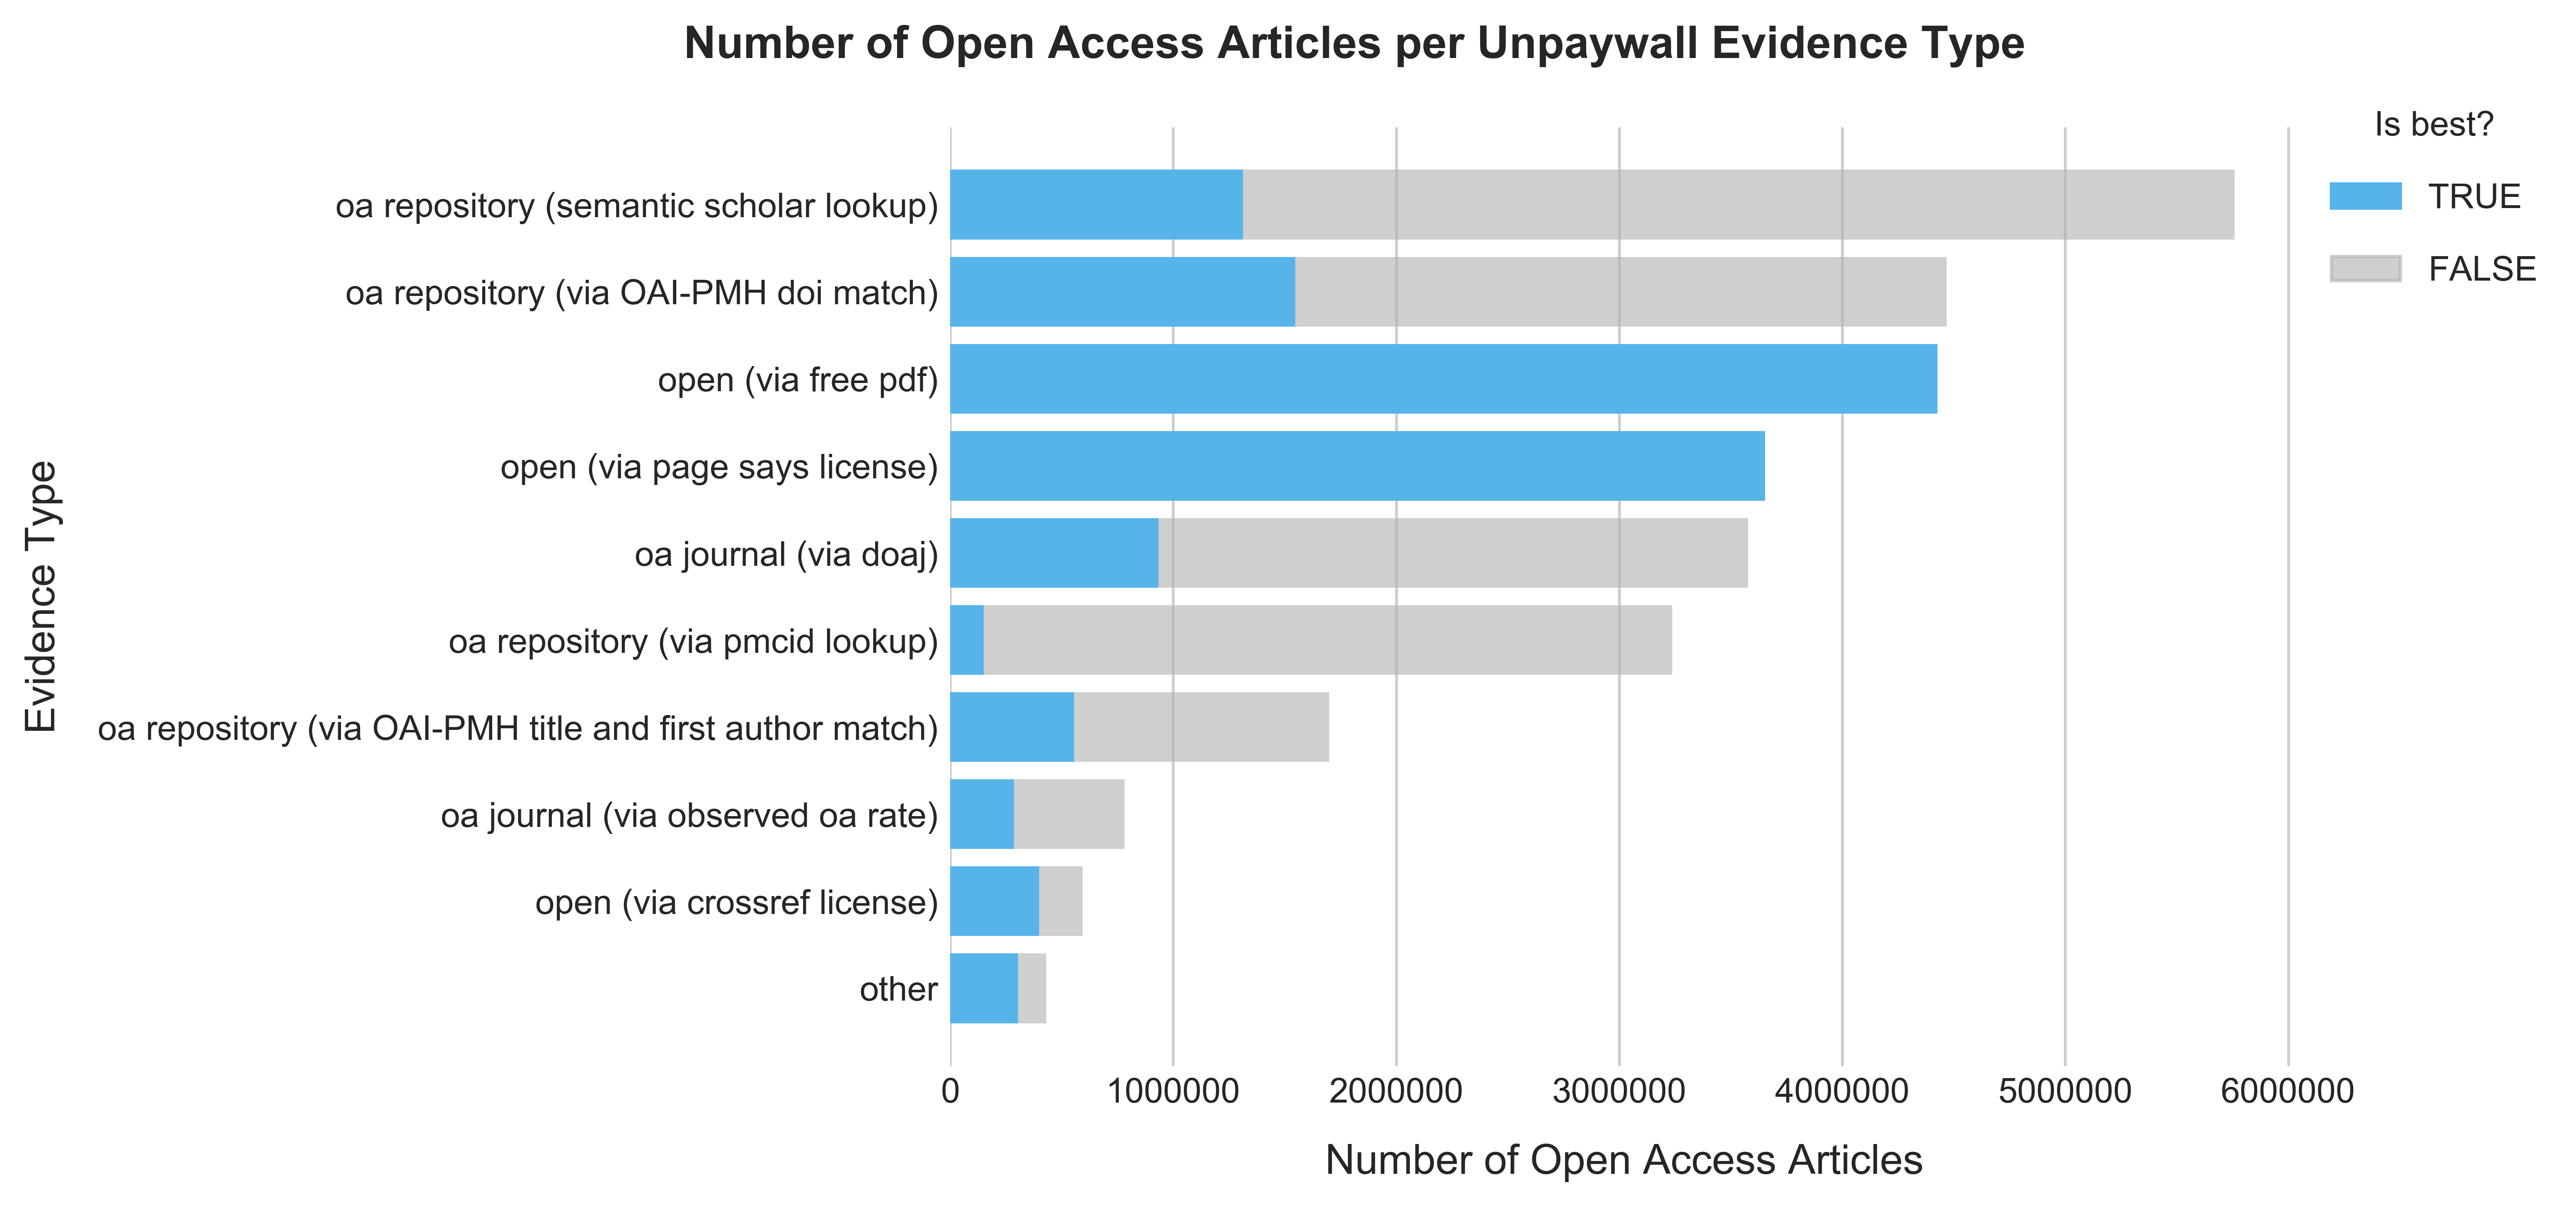

In [19]:
evidence_grouped_plot_df = evidence_grouped_df \
                            .groupby(['evidence', 'is_best']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .sort_values(by=['number_of_articles'], ascending=True) \
                            .reset_index(drop=True)

articles_per_type_grouped_plot_df = articles_per_type_grouped_df \
                                    .sort_values(by=['number_of_articles'], ascending=True) \
                                    .reset_index(drop=True)

y1 = articles_per_type_grouped_plot_df.evidence
x_total = articles_per_type_grouped_plot_df.number_of_articles
x_stacked = evidence_grouped_plot_df[evidence_grouped_plot_df.is_best == True] \
                        .set_index('evidence') \
                        .reindex(index=articles_per_type_grouped_plot_df['evidence']) \
                        .reset_index().number_of_articles

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [7, 5]
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = plt.barh(y1, x_total, color='#b3b3b3a0')
ax2 = plt.barh(y1, x_stacked, color='#56B4E9')

plt.title('Number of Open Access Articles per Unpaywall Evidence Type', 
          fontdict={'fontsize': 13, 'fontweight': 600}, pad=20, x=0.3)
plt.xlabel('Number of Open Access Articles', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

is_best_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_best_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_best_patch, is_not_best_patch], title='Is best?', 
           fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.show()

The figure provides two types of evidence that were not specifically mentioned in the previous work: 'oa repository (semantic scholar lookup)' and 'oa journal (via observed rate)'. Apparently, these evidence types are responsible for the overall increase in articles between the two data dumps from February and November 2019.

In [20]:
y1 = evidence_grouped_df.sort_values(by=['year'], ascending=True) \
                        .reset_index(drop=False) \
                        ['year'].dt.year.unique()

plt.style.use('seaborn-whitegrid')

fig, (axes) = plt.subplots(nrows=5, 
                           ncols=2, 
                           sharex=True, 
                           sharey=True, 
                           figsize=(12,12))

# get a one-dimensional array
axes = axes.reshape(-1)

fig.suptitle('Unpaywall Open Access Evidence Categories per Year', 
             fontsize=15, 
             fontweight=600, 
             x=0.53,
             y=1.04)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(5,2,i, sharey=axes[0], sharex=axes[0])    
    
    if i % 2 == 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    evidence = evidence_grouped_df.evidence.unique()[i-1]

    x_total = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    x_stacked = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .loc[evidence_grouped_df.is_best == True] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    ax = plt.bar(y1, x_total, color='#b3b3b3a0')
    ax = plt.bar(y1, x_stacked, color='#56B4E9')
    plt.title(evidence, fontdict={'fontsize': 12, 'fontweight': 500}, pad=0.2)
    
    plt.grid(False, which='both', axis='x')
    plt.box(False)

# common xlabel   
fig.text(0.52, -0.03, 'Publication Year', ha='center', 
         fontdict={'fontsize': 13, 'fontweight': 500})

# common ylabel
fig.text(-0.04, 0.5, 'Number of Open Access Articles', va='center', rotation='vertical', 
         fontdict={'fontsize': 13, 'fontweight': 500})

is_best_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_best_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
fig.legend(handles=[is_best_patch, is_not_best_patch], title='Is best?', 
           fontsize='large', title_fontsize='x-large', 
           bbox_to_anchor=(1.15, 0.95), labelspacing=1.2)

plt.tight_layout()

plt.show()

## Overlap of Open Access Provision and Evidence Types

Owing to possible multiple associations between an article and evidence types in Unpaywall, we investigate the intersection between host types in the next step. Again, we compare the results with the previous results.

In [21]:
HOST_TYPE_INTERSECT_08_12_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        count(distinct(doi)) as number_of_articles 
                                    FROM 
                                        (SELECT doi, year,
                                            STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) 
                                        as host_type_count 
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" 
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles desc
                                    """

HOST_TYPE_INTERSECT_13_18_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        count(distinct(doi)) as number_of_articles 
                                    FROM 
                                        (SELECT doi, year, 
                                        STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) as host_type_count
                                        FROM {upw_13_18}, UNNEST (oa_locations) 
                                        WHERE genre="journal-article" AND year < 2019 
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles desc
                                    """

In [22]:
host_type_08_12_intersect_df = client.query(HOST_TYPE_INTERSECT_08_12_QUERY).to_dataframe()
host_type_13_18_intersect_df = client.query(HOST_TYPE_INTERSECT_13_18_QUERY).to_dataframe()
host_type_intersect_df = pd.concat([host_type_08_12_intersect_df, 
                                    host_type_13_18_intersect_df])

host_type_intersect_df.year = pd.to_datetime(host_type_intersect_df.year \
                                             .apply(lambda x: str(x) + "-01-01"))

host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher', 'host'] = 'Publisher only'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher,repository', 
         'host'] = 'Publisher & Repository'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'repository', 
         'host'] = 'Repositories only'

In [23]:
articles_total_by_year_df = df.groupby(['year']).n.sum().to_frame().reset_index()
articles_total_by_year_df.columns = ['year', 'all_articles']

host_type_intersect_df = pd.merge(articles_total_by_year_df, 
                                  host_type_intersect_df, on='year', how='right')

host_type_intersect_df = host_type_intersect_df.groupby(['year', 'host']) \
                                    .sum().eval('prop = number_of_articles/all_articles') \
                                    .reset_index()

host_type_intersect_df.head()

year                    host  all_articles  number_of_articles  \
0 2008-01-01  Publisher & Repository       2068254              184598   
1 2008-01-01          Publisher only       2068254              202894   
2 2008-01-01       Repositories only       2068254              258587   
3 2009-01-01  Publisher & Repository       2258784              216379   
4 2009-01-01          Publisher only       2258784              231117   

       prop  
0  0.089253  
1  0.098099  
2  0.125027  
3  0.095794  
4  0.102319

In [24]:
host_type_all = host_type_intersect_df.copy()
host_type_all['prop'] = host_type_intersect_df.groupby(['year'])['prop'] \
                    .transform(lambda x: x.sum())

This time we are using the [seaborn](https://seaborn.pydata.org/index.html) package for generating bar plots. Seaborn is a visualization library which is build on top of matplotlib. It is well designed to fit with pandas DataFrames and it also enables smoother plots. Also, we can continue to use matplotlib methods.

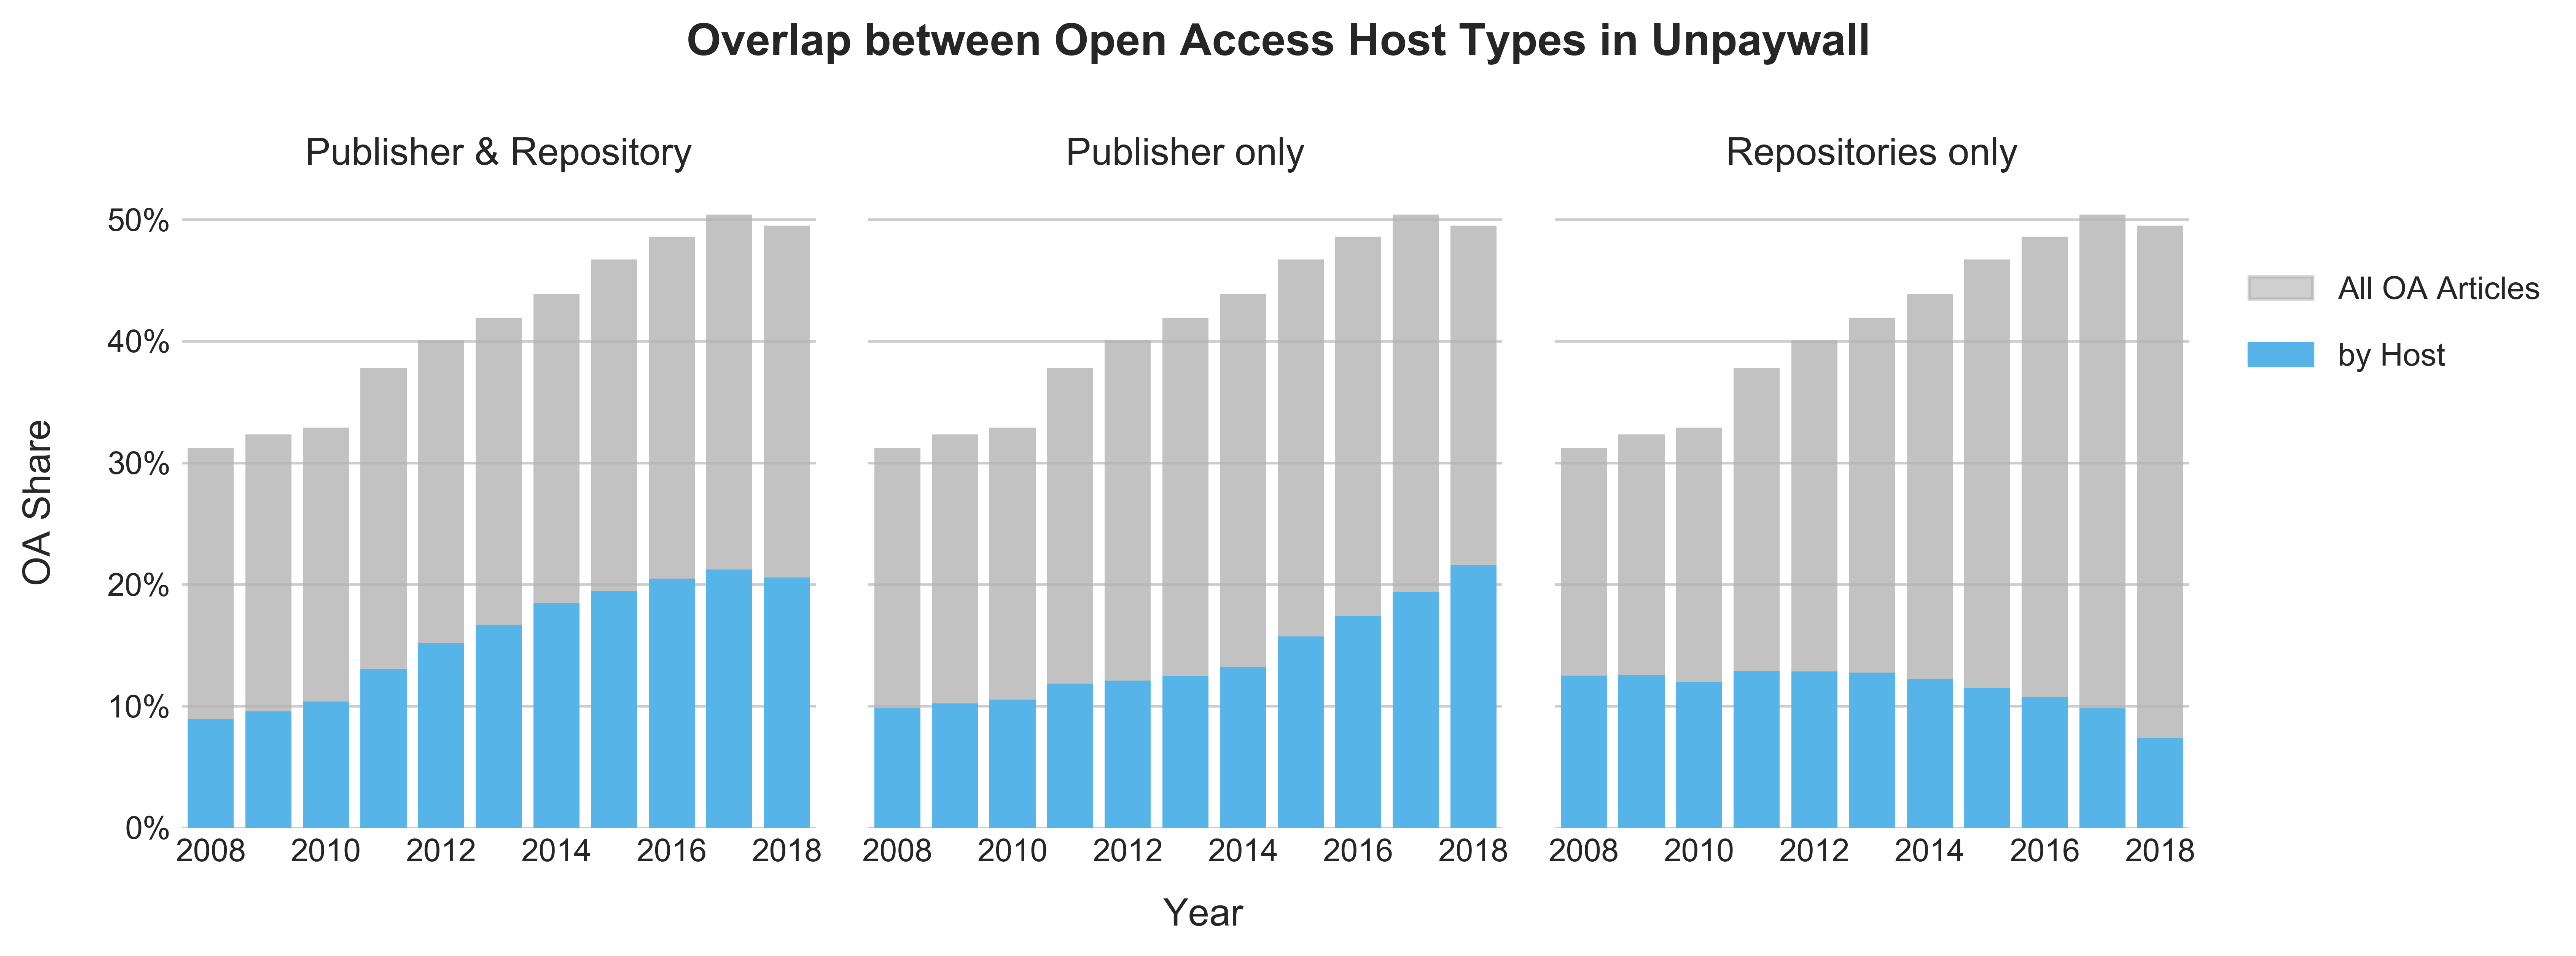

In [25]:
x = host_type_intersect_df['year'].dt.year
y = host_type_all.prop

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5] 

fig,(axes) = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Overlap between Open Access Host Types in Unpaywall', 
             fontsize=14, 
             fontweight=600,
             x=0.48,
             y=1.10)
    
for i, host in enumerate(host_type_intersect_df.host.unique(), 1):
    ax = plt.subplot(1,3,i)
    y_stacked = host_type_intersect_df[host_type_intersect_df.host == host].prop
    sns.barplot(x, y, color='#b3b3b3a0', alpha=0.8, saturation=1, ci=None)
    sns.barplot(x, y_stacked, color='#56B4E9', alpha=1, saturation=1, ci=None)
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})
    
    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')
    ax.set(xlabel='', ylabel='')
    for label in ax.get_xticklabels()[1::2]:
        label.set_visible(False)
        
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Share', va='center', rotation='vertical', 
         fontdict={'fontsize': 12, 'fontweight': 500})
    
by_host_patch = mpatches.Patch(color='#56B4E9', label='by Host')
all_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='All OA Articles')
plt.legend(handles=[all_oa_patch, by_host_patch], 
           bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

plt.tight_layout()

plt.show()

The figure shows that, in terms of percentage, fewer articles were found on publisher websites than in the results of the blog article. Indeed, 73% of all open access full-texts are available through publisher websites which is a total of 9,970,245 articles. This is a decrease by almost 9% compared to the previous results. Also, the proportion of articles that are not archived in a repository has declined from 56% to 35%. Consequently, the proportion of articles that are available from both the publisher websites, as well as those that are archived in a repository have increased from 26% to 39%.

In [26]:
EVIDENCE_SINGLE_CAT_08_12_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article"
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

EVIDENCE_SINGLE_CAT_13_18_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_13_18}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" AND year < 2019
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

In [27]:
evidence_categories_08_12_df = client.query(EVIDENCE_SINGLE_CAT_08_12_QUERY).to_dataframe()
evidence_categories_13_18_df = client.query(EVIDENCE_SINGLE_CAT_13_18_QUERY).to_dataframe()
evidence_categories_df = pd.concat([evidence_categories_08_12_df, 
                                    evidence_categories_13_18_df])

evidence_categories_df = evidence_categories_df.groupby(['ev_cat']) \
                                    .sum().reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_categories_df.head()

ev_cat  number_of_articles
0                                open (via free pdf)             2042872
1            oa repository (semantic scholar lookup)             1233239
2  oa repository (semantic scholar lookup)&open (...              867351
3  oa repository (via OAI-PMH doi match)&oa repos...              535673
4  oa journal (via doaj)&open (via page says lice...              533464

In [28]:
evidence_single_cat_df = evidence_df.groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .reset_index()

evidence_single_cat_df = pd.merge(evidence_single_cat_df, evidence_categories_df, 
                                 how='left', left_on=['evidence'], right_on=['ev_cat']) \
                                    .drop(['ev_cat'], axis=1) 
evidence_single_cat_df.columns = ['evidence', 'number_of_articles', 'number_of_single_cat']

In [29]:
evidence_single_cat_df.evidence = evidence_single_cat_df \
                                    .evidence.replace(list_of_small_evidence_types, 'other')

evidence_single_cat_grouped_df = evidence_single_cat_df.groupby(['evidence']) \
                                    .sum() \
                                    .eval('prop = number_of_single_cat/number_of_articles') \
                                    .reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_single_cat_grouped_df

evidence  number_of_articles  \
0            oa repository (semantic scholar lookup)             5759641   
1              oa repository (via OAI-PMH doi match)             4467382   
2                                open (via free pdf)             4427452   
3                       open (via page says license)             3653314   
4                              oa journal (via doaj)             3577409   
5                   oa repository (via pmcid lookup)             3237547   
6  oa repository (via OAI-PMH title and first aut...             1699654   
7                  oa journal (via observed oa rate)              781574   
8                        open (via crossref license)              594003   
9                                              other              430653   

   number_of_single_cat      prop  
0               1233239  0.214117  
1                439084  0.098287  
2               2042872  0.461410  
3                463163  0.126779  
4                412369  0.115270  
5                107429  0.033182  
6                372617  0.219231  
7                233925  0.299300  
8                273713  0.460794  
9                179703  0.417280

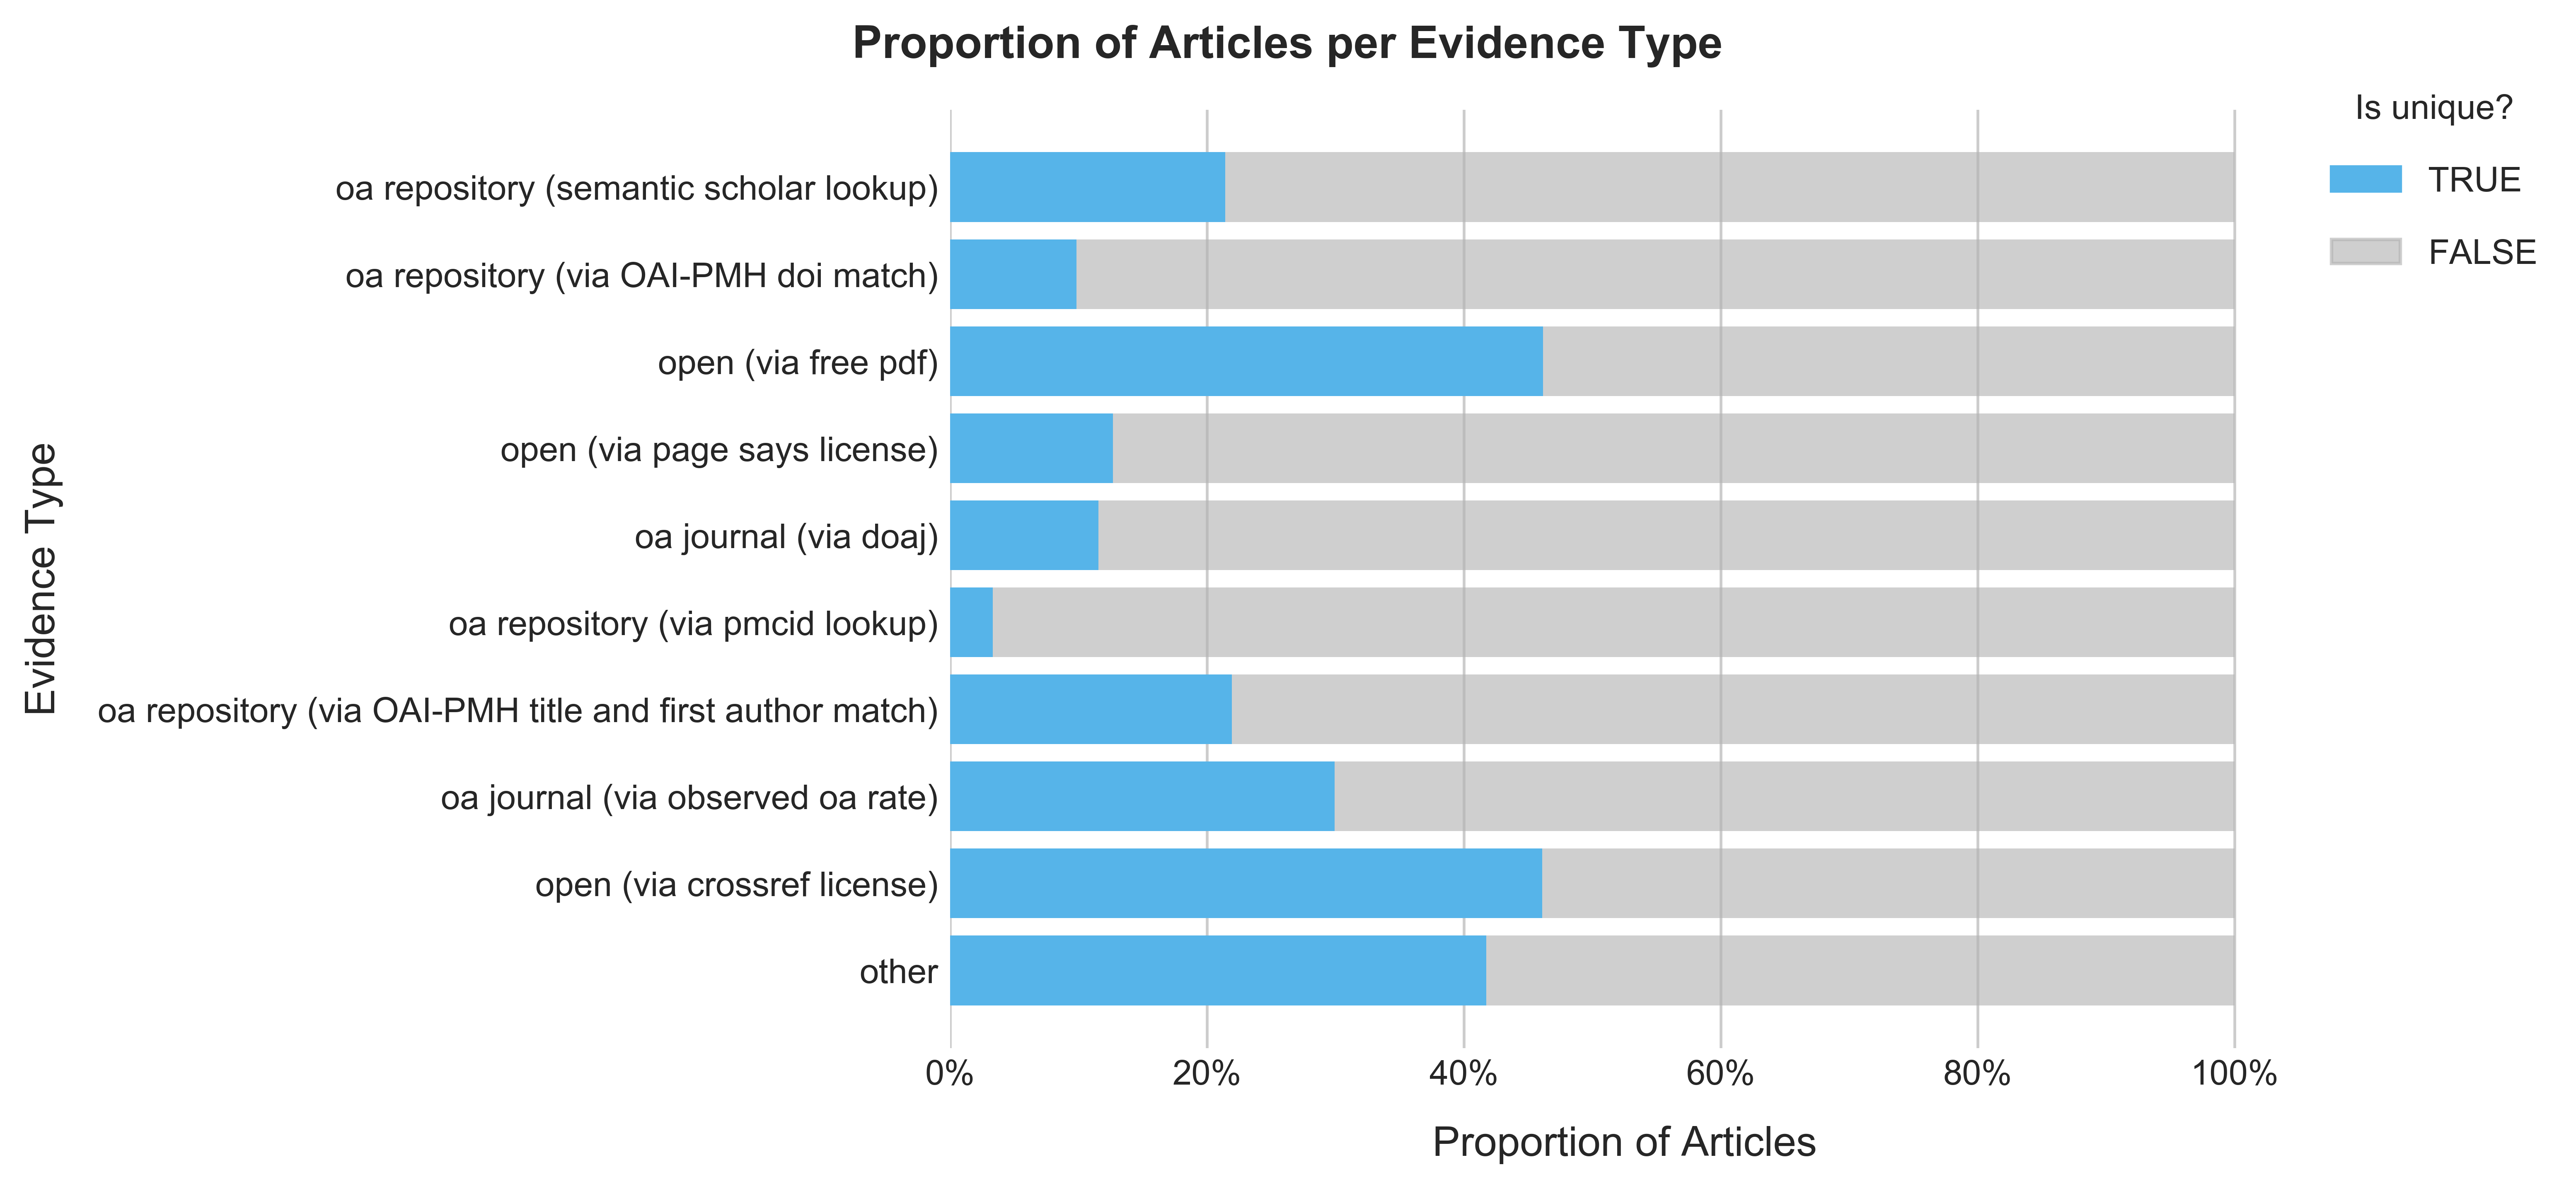

In [30]:
y1 = evidence_single_cat_grouped_df \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True).evidence

x_total = evidence_single_cat_grouped_df.groupby(['evidence']) \
                .number_of_articles.count() \
                .to_frame().reset_index() \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True) \
                .number_of_articles


x_stacked = evidence_single_cat_grouped_df \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True) \
                .prop

fig, ax = plt.subplots(figsize=(7,5))

plt.style.use('seaborn-whitegrid')
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = plt.barh(y1, x_total, color='#b3b3b3a0')
ax2 = plt.barh(y1, x_stacked, color='#56B4E9')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Proportion of Articles per Evidence Type', 
          fontdict={'fontsize': 13, 'fontweight': 600}, x=0.25, pad=15)
plt.xlabel('Proportion of Articles', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

is_unique_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_unique_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_unique_patch, is_not_unique_patch], title='Is unique?', 
           fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.show()

While openly forms of open access provision identified via pdf or license are still evidence types with a most often unique appearance, it can be seen that the share has decreased, compared to the results from the previous database snapshot. On the other hand, the share of unique occurences of less frequent evidence types which were collated in the category other has increased rapidly. 

To visualize the intersection between multiple evidence types, we are using the [UpSetPlot](https://upsetplot.readthedocs.io/en/stable/) package which is better maintained in contrast to [py-upset](https://github.com/ImSoErgodic/py-upset). It offers better support for pandas and is also well documented. Especially the input format for the UpSet plot is well described.

The input format can be generated with the `from_memberships` method. It accepts two parameters: a nested list with elements corresponding to a set and secondly a list containing additional data which has the same length as the nested list.

In [31]:
evidence_categories_upset_df = evidence_categories_df.groupby(['ev_cat']) \
                                        .sum().reset_index() \
                                        .sort_values(by=['number_of_articles'], 
                                                     ascending=False) \
                                        .reset_index(drop=True)

In [32]:
# subset of fifteen most frequent distinct evidence types combinations
evidence_categories_upset_most_frequent = evidence_categories_upset_df[:15]

ev_list = evidence_categories_upset_most_frequent.ev_cat.tolist()
ev_list = [ev.split('&') for ev in ev_list]
n_list = evidence_categories_upset_most_frequent.number_of_articles.tolist()
evidence_categories_upset_expr = upsetplot.from_memberships(ev_list, data=n_list)

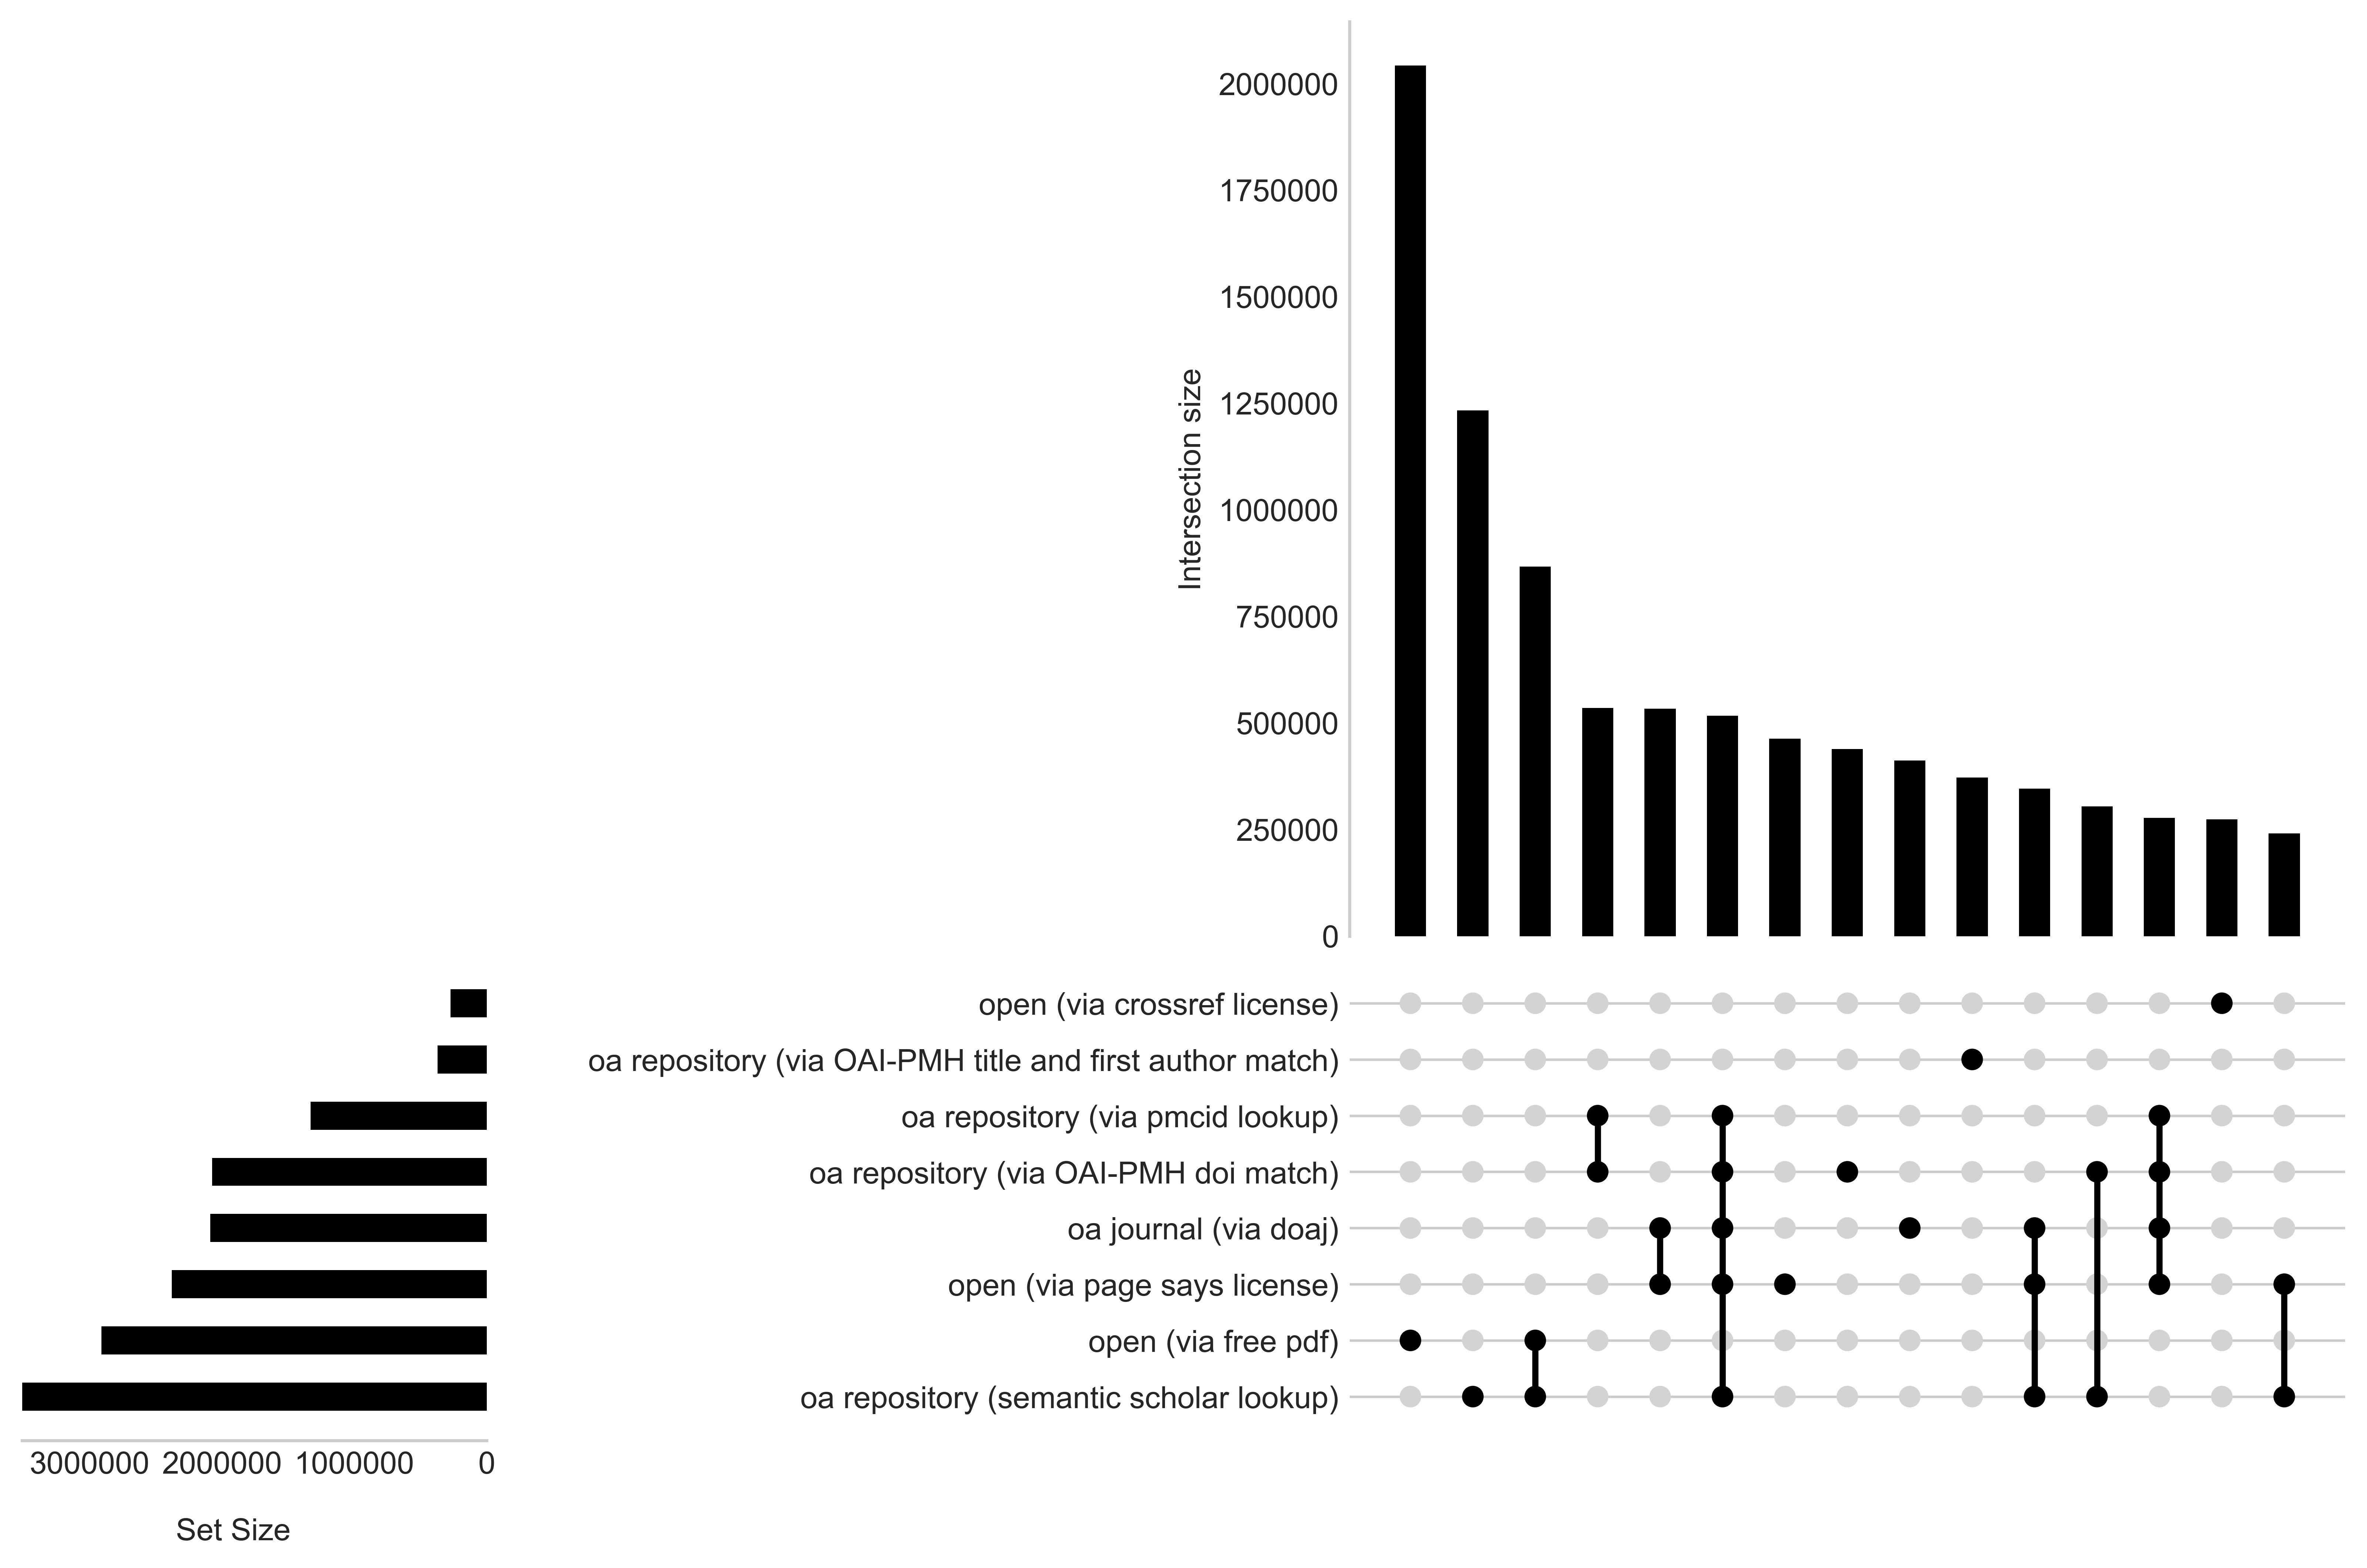

In [33]:
fig = plt.figure(figsize=(10,6))

axes = upsetplot.UpSet(evidence_categories_upset_expr, 
                sort_by='cardinality',
                sort_categories_by='cardinality',
                element_size=20, 
                intersection_plot_elements=15, 
                totals_plot_elements=7
               ).plot(fig=fig)

ax1 = axes['intersections']
ax1.yaxis.grid(False)

ax2 = axes['shading']

ax3 = axes['matrix']

ax4 = axes['totals']
ax4.xaxis.grid(False)

# reduce overlap with text
plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1, wspace=0, hspace=0)

fig.text(0.1, -0.07, 'Set Size', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 500})

# delete shading axis for better readability
fig.delaxes(ax2)
    
plt.show()

## Discussion and Conclusion

In this blog post, we provided an updated analysis of open access evidences in Unpaywall by examining database snapshots obtained from Unpaywall. Using Python, we were able to find 13,569,137 scholarly articles in Unpaywall in the period from 2008 to 2018, that are freely available. Fortunately, we can compare these results with the previous database snapshot from February 2019 which were described in the mentioned blog article. Thusly we can interpret upcoming trends more precisely. 

Based on the previous results, our analysis exposes an increase of open access full-texts by 6% from 37% to 43%. Furthermore, we were able to identify new evidence types that were introduced in the latest database snapshot. Altogether, this suggests that more articles had left closed access and Unpaywall was able to link more DOI’s to articles found in the newly introduced evidence types.

Additionally this work demonstrates similarities between data analysis in Python and R. Due to the fact that this work is based on translated R source code, we´ve learned plenty of approaches to face upcoming data analysis projects. 